# 7장 앙상블 학습과 랜덤 포레스트


일련의 예측기로 가장 좋은 모델 하나 보다 더 좋은 예측을 할 수 있다.  
일련의 예측기를 __앙상블__ 이라고 부르기 때문에 이를 __앙상블학습__ 이라고 한다.  

예를들어 훈련세트로 부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정트리 분류기를 훈련시킬 수 있다.  
예측을 하려면 모들 개별 트리의 예측을 구하면 된다. 그다음 가장 많은 선택을 받은 클래스를 예측으로 삼는다.  
결정 트리의 앙상블을 __랜덤 포레스트__ 라고 한다. 간단한 방법이지만 랜덤 포레스트는 오늘날 가장 강력한 머신러닝 알고리즘 중 하나이다.  

프로젝트의 마지막에 다다르면 흔히 앙상블 방법을 사용하여 이미 만든 여러 괜찮은 예측기를 만든다.  


## 7.1 투표 기반 분류기

정확도가 80%인 분류기 여러개를 훈련 시켰다고 가정하자. 아마도 로지스틱, SVM, 랜덤 포레스트, K-NN 등을 가지고 있을 수 있다.  
더 좋은 분류기를 만드는 매우 간단한 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것이다. 이렇게 다수결 투표로 정해지는 분류기를 __직접 투표(hard voting)__ 분류기 라고 한다.  

이 다수결 투표 분류기가 앙상블에 포함된 개별 분류기 중 가장 뛰어난 것보다도 정확도가 높을 경우가 많다.  
사실 각 분류기가 __약한 학습기__일지라도 충분하게 많고 다양하다면 앙상블은 __강한 학습기__가 될 수 있다.  



In [44]:
from scipy.stats import binom
from pprint import pprint
pprint(1 - binom.cdf(499, 1000, 0.51))
pprint(1 - binom.cdf(4999, 10000, 0.51))

0.7467502275561786
0.9777976478701533


- 이유 : 대수의 법칙 때문(law of large numbers)

`TIP`  
앙상블 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다.  
다양한 분류기를 얻는 한 가지방법은 각기 다른 알고리즘으로 학습시키는 것이다.  
이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킨다.  

In [71]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
X,y = make_moons(n_samples = 500, noise = 0.30, random_state =42)

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state =42)

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(solver='liblinear', random_state=42)
rnd_clf = RandomForestClassifier(n_estimators=10, random_state=42)
svm_clf = SVC(gamma='auto', random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='hard', weights=None)

In [74]:

from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


책에는 세 모델을 Voting으로 앙상블한 VotingClassifier가 가장 성능이 좋았지만  
나는 RandomForest가 가장 정확도가 높게나옴

모든 분류기가 클래스의 확률을 예측할 수 있으면(즉, sklearn에서 predict_proba() 메서드가 있으면) 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측할 수 있다.  
이를 __간접 투표(Soft voting)__ 이라고한다.  

_SVC는 기본값에서는 클래스 확률을 제공하지 않으므로 probability 매개변수를 True로 지정해야한다._  
(서포트 벡터 머신상에서 probability = True 를 지정하면 교차 검증을 사용하여 클래스 확률을 만들어낸다.  속도는 느려지지만 predict_proba 메서드를 사용할 수 있다.)  

SoftVoting 예)

In [75]:
svm_clf2 = SVC(gamma='auto', random_state = 42, probability=True)

In [76]:
voting_clf2 = VotingClassifier(
            estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc2', svm_clf2)],
            voting = 'soft')

voting_clf2.fit(X_train,y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False)), ('rf', Rando...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

In [77]:
for clf in (log_clf, rnd_clf, svm_clf, svm_clf2, voting_clf, voting_clf2):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
SVC 0.888
VotingClassifier 0.896
VotingClassifier 0.912


In [78]:
print("SoftVoting accuracy : {:}".format(accuracy_score(y_test, y_pred)))

SoftVoting accuracy : 0.912


## 7.2 배깅과 페이스팅

__bagging(bootstrap aggregaing)__ : 중복을 허용하여 샘플링 하는 방식.  
__pasting__ : 중복을 허용하지 않고 샘플링 하는 방법.  

다시말해 배깅과 페이스팅에서는 같은 훈련 샘플을 여러개의 예측기에 걸쳐 사용할 수 있다.  
하지만 배깅만이 한 예측기를 위해 같은 훈련샘플을 여러번 샘플링 할 수 있다.  

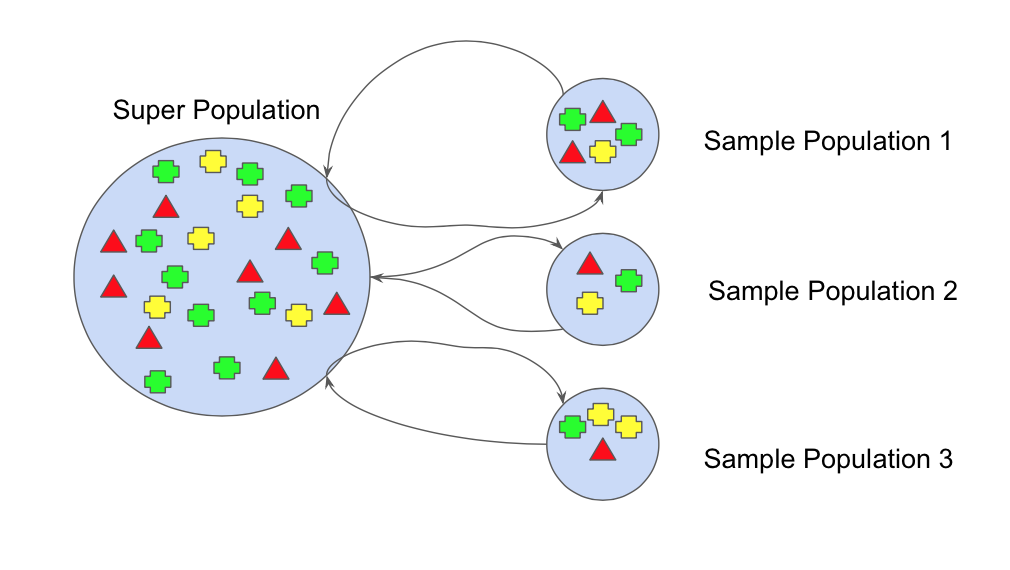

### 각 무작위 샘플링에 대해서 예측기 훈련을 수행한다.  
훈련을 마치면 앙상블은 모든 에측기의 예측을 모아서 새로운 샘플에 대한 예측을 만든다.  
수집 함수는 전형적으로 분류일때는 __통계적 최빈값__ 이고 회귀에 대해서는 __평균__을 계산한다.  

_개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 훨씬 크게 편향 되어있지만(bias) 수집 함수를 통과하면 편향과 분산이 모두 감소한다(bias, variance)_  

_예측기는 동시에 다른 CPU코어나 서버에 병렬로 학습 시킬 수 있다.  이와 유사하게 예측도 병렬로 수행 할 수 있다._


### 7.2.1 사이킷런의 배깅과 페이스팅

사이킷런은 배깅과 페이스팅을 위해 BaggingClassifier를 제공한다.(회귀일 경우 BaggingRegressor)  
다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드이다.  
각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련된다.  

페이스팅을 사용하려면 boostrap = False로 지정하면 된다.  

In [79]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
        DecisionTreeClassifier(), n_estimators = 500,
        max_samples =100, bootstrap=True, n_jobs =-1)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [80]:
accuracy_score(y_test,y_pred)

0.904

In [81]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


_배깅을 사용했을때 정확도가 8%가량 상승했다._

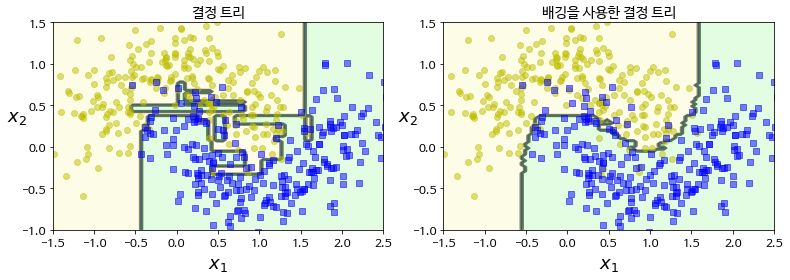

앙상블의 예측이 결정트리 하나의 예측보다 훨씬 일반화가 잘된것으로 보인다.  
`앙상블은 비슷한 편향에서 더 작은 분산을 만든다.`  

부트스트래핑은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 배깅이 페이스팅보다 편향이 조금 더 높다.  
하지만 이는 예측기의 상관관계를 줄이므로 앙상블의 분산을 감소시킨다.   
전반적으로 배깅이 더 나은 모델을 만들기 때문에 더 선호되지만  
시간과 CPU에 여유가있다면 교차검증으로 배깅과 페이스팅 모두 평가해서 더 나은 쪽을 선택하는 것이 낫다.  

### 7.2.2 oob 평가

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 수도 있다.  
BaggingClassifier은 기본값으로 중복을 허용하여 훈련 세트의 크기만큼인 m개의 샘플을 선택한다.  
이는 평균적으로 각 예측기에 훈련 샘플의 63%정도만 샘플링 된다는 것을 의미한다.  ($(1-1/m)^m = 1 - e^{-1} = 0.632$)  
선택되지 않은 훈련 샘플의 나머지 37%를 __oob샘플__ 이라고 한다. 예측기바다 남겨진 37%는 모두 다르다.  

예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검즈을 사용하지 않고 oob 샘플을 사용하여 평가 할 수 있다. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.  

사이킷런에서 __BaggingClassifier__를 만들때 oob_score = True 로 지정하면 훈련이 끝난 후 자동으로 oob평가를 수행한다.  

In [82]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap = True, n_jobs = -1 , oob_score = True) ##oob_score 파라미터를 통해 oob 평가를 할건지 결정

bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.904

In [83]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.912

테스트세트에서의 평가결과와 oob socre에서의 평가결과가 비슷하다는걸 말하고 싶은거임. 

In [84]:
bag_clf.oob_decision_function_

array([[0.36413043, 0.63586957],
       [0.31428571, 0.68571429],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.08588957, 0.91411043],
       [0.28484848, 0.71515152],
       [0.        , 1.        ],
       [0.99456522, 0.00543478],
       [0.98947368, 0.01052632],
       [0.80104712, 0.19895288],
       [0.00520833, 0.99479167],
       [0.76404494, 0.23595506],
       [0.82967033, 0.17032967],
       [0.95721925, 0.04278075],
       [0.09289617, 0.90710383],
       [0.00552486, 0.99447514],
       [0.97860963, 0.02139037],
       [0.94936709, 0.05063291],
       [1.        , 0.        ],
       [0.03488372, 0.96511628],
       [0.31382979, 0.68617021],
       [0.90163934, 0.09836066],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.00534759, 0.99465241],
       [0.63874346, 0.36125654],
       [0.

## 7.3 랜덤패치와 랜덤 서브스페이스

BaggingClassifier는 특성 샘플링도 지원한다. max_features, bootstrap_features 두 매개변수로 조절된다.  
작동 방식은 max_samples, boostrap과 동일하지만 샘플이 아니고 특성에 대한 샘플링이다.  
따라서 각 예측기는 무작위로 선택한 입력 특성의 일부분으로 훈련된다.  
이는 특히 이미지와 같은 고차원의 데이터셋을 다룰 때 유용하다.  
훈련 특성과 샘플을 모두 샘플링하는 것을 __랜덤 패치__라고 한다.  
훈련 샘플을 모두 사용하고(즉, bootsrap = False, max_samples = 1.0) 특성은 샘플링하는(bootstrap_features = True, max_fetures<1.0)인것을 __랜덤 서브스페이스__ 라고한다.  

_특성 샘플링은 더 다양한 예측기를 만들어 편향은 증가시키지만 분산은 감소시킨다_

## 7.4 랜덤 포레스트

랜덤 포레스트는 일반적으로 배깅 방법(또는 페이스팅)을 적용한 결정 트리의 앙상블이다.  
전형적으로 max_samples를 훈련 세트의 크기로 결정한다.  
Bagging Classifier에 DecisionTreeClassifier를 넣어 만드는 대신 결정 트리에 최적화 되어 사용하기 편리한 RandomForestClassifier를 사용할 수 있다.  
`결정 트리 이외의 모델을 앙상블 하고 싶을때 BaggingClassifier은 여전히 유용함`  


In [85]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes = 16, n_jobs = -1)
rnd_clf.fit(X_train ,y_train)

y_pred_clf = rnd_clf.predict(X_test)

accuracy_score(y_test, y_pred_clf)

0.92

랜덤 포레스트 알고리즘은 트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는 식으로 무작위성을 더 주입한다.  
이는 결국 트리를 더욱 다양하게 만들고 편향을 손해 보는 대신 분산을 낮추어 훌륭한 모델을 만들어낸다. 

_아래 코드는 BaggingClassifier을 이용하여 RandomForestClassifier과 유사한 모델은 만든 것_

In [86]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", #결정트리의 파라미터
    max_leaf_nodes = 16 #결정트리의 파라미터. 
                          ),
    n_estimators = 500,
    max_samples = 1.0,
    bootstrap = True,
    n_jobs = -1 )

bag_clf.fit(X_train, y_train)
bag_pred_clf = bag_clf.predict(X_test)
accuracy_score(y_test, bag_pred_clf)

0.904

### 7.4.1 엑스트라 트리

랜덤 포레스트에서 트리를 만들때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다.  
트리를 더욱 무작위하게 만들기 위해 최적의 임곗값을 찾는 대신 후보 특성을 사용해 무작위로 분할한 다음 그중에서 최상의 분할을 선택한다.  

이와 같이 극단적으로 무작위한 트리의 랜덤 포레스트를 __익스트림 랜덤 트리 앙상블(줄여서 엑스트라 트리)__ 라 한다.  

여기서도 편향이 늘어나지만 분산을 낮추게된다.  
모든 노드에서 특성마다 가장 최적의 임곗값을 찾는것이 트리 알고리즘에서 시간이 가장 많이 소요되는 것중 하나이므로 엑스트라 트리는 일반적인 랜덤 포레스트보다 훨씬 빠르다.  

엑스트라 트리를 만들려면 사이킷런의 ExtratreesClassifier를 사용한다. 사용법은 RandomForestClassifier와 같다.

`TIP`  
엑스트라 트리와 일반적인 랜덤 포레스트 중 무엇이 더 나을지 예단하기는 어렵다.  
일반적으로 둘 다 시도 해보고 교차 검증으료 비교해보는 것이 좋다.

### 7.4.2 특성 중요도